In [1]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [2]:
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/t/zoom_40m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/t/zoom_40m_label.npy')   

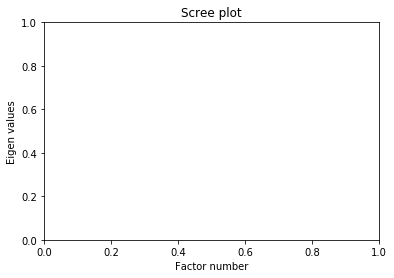

[0.15486569 0.09165271 0.03628165 0.01683337]
[38507.91833739 29624.09524856 18638.71407892 12695.7382318 ]


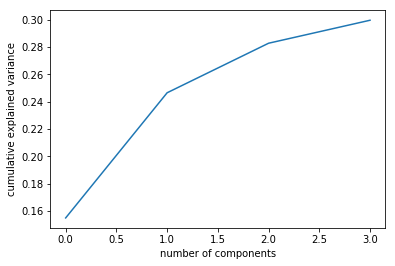

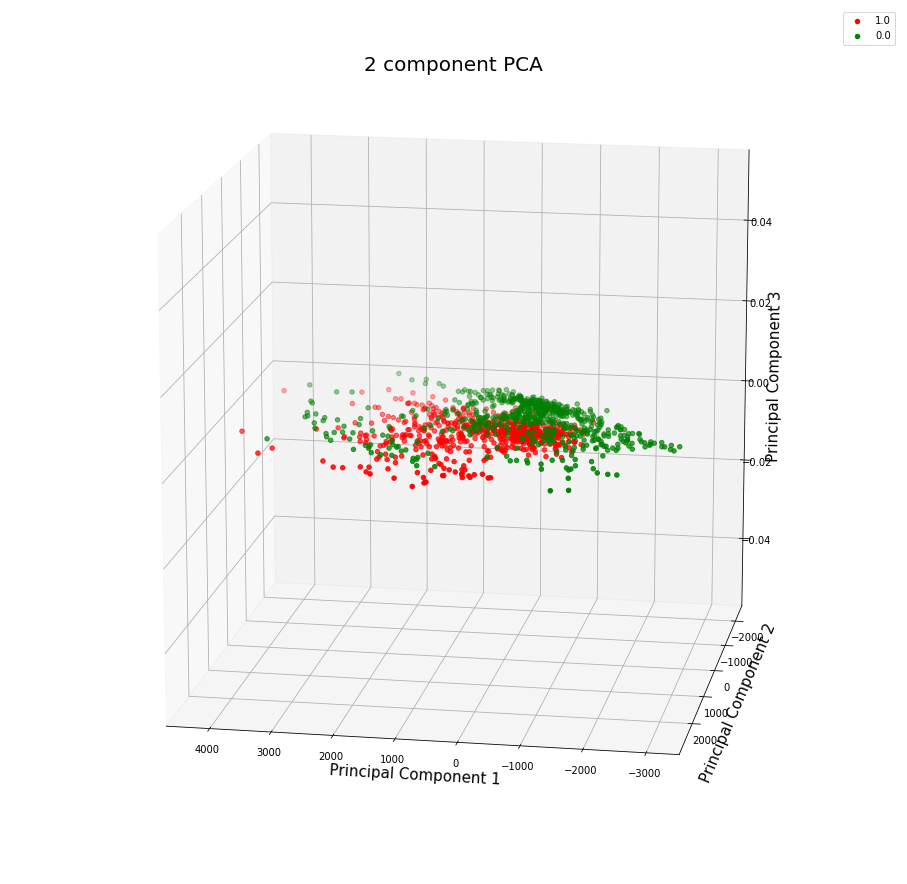

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
d = {'type': Y}
df = pd.DataFrame(data=d)
# Standardizing the features
dataset_size = len(X)

acp = PCA(svd_solver='full')
X=X.reshape(dataset_size,-2)




plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()
pca = PCA(n_components=4)

principalComponents = pca.fit_transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal cmponent 4'])
finalDf = pd.concat([principalDf, df[['type']]], axis = 1)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d') 
ax = fig.gca(projection='3d')
#30 70
ax.view_init(15,100)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1.0,0.0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20)
ax.legend(targets)
ax.grid()
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)

In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

In [5]:
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]

In [6]:
#☻n split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0
print("set d'entrainement Shape:", X_train.shape)
print("set de test Shape:", X_test.shape)

set d'entrainement Shape: (1000, 7500)
set de test Shape: (250, 7500)


In [7]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)


IndexError: tuple index out of range

In [ ]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('LR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    #print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')
    return
defineModels()

In [ ]:
"""
LR: 0.809615 (0.070679)
RF: 0.799679 (0.087051)
KNN: 0.817308 (0.064925)
SVM: 0.721987 (0.084286)
LSVM: 0.779615 (0.082447)
GNB: 0.739359 (0.079943)
DTC: 0.704295 (0.055464)
GBC: 0.797115 (0.066274)
LDA: 0.741603 (0.060659)
"""